# 1D harmonic oscillator physics-informed neural network (PINN) using JAX

This notebook contains a JAX implementation of the PINN example presented in the blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using [FLAX](https://flax.readthedocs.io/en/latest/) and [JAX](https://docs.jax.dev/en/latest/index.html), using the following environment set up:

> Recommended to use [uv](https://docs.astral.sh/uv/) for the environment management.



```bash
uv venv .venv
source .venv/bin/activate  # On Windows use `venv\Scripts\activate`
uv pip install jupyter numpy matplotlib plotly tqdm loguru
uv pip install jax jaxlib
uv pip install flax optax
```



In [1]:
from PIL import Image
import time


import tempfile
from tqdm.notebook import tqdm
from loguru import logger

import jax
import jax.numpy as jnp
from jax import jit, value_and_grad
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

In [2]:
# Methods for plotting and saving GIFs


def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(
        fp=outfile,
        format="GIF",
        append_images=imgs[1:],
        save_all=True,
        duration=int(1000 / fps),
        loop=loop,
    )


def plot_result(x, y, x_train, y_train, yh, xp=None, step: int = 0):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(
        x,
        yh,
        color="tab:blue",
        linewidth=4,
        alpha=0.8,
        label="Neural network prediction",
    )
    plt.scatter(
        x_train, y_train, s=60, color="tab:orange", alpha=0.4, label="Training data"
    )
    if xp is not None:
        plt.scatter(
            xp,
            jnp.zeros_like(xp),
            s=60,
            color="tab:green",
            alpha=0.4,
            label="Physics loss training locations",
        )
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, f"Training step: {step}", fontsize="xx-large", color="k")
    plt.axis("off")
    plt.tight_layout()


In [3]:
# Definition for the exact solution to the 1D underdamped harmonic oscillator problem


def oscillator(d, w0, x, initial_position=1.0):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/

    Args:
        d: Damping coefficient
        w0: Natural frequency
        x: Time points
        initial_position: Initial position at t=0 (default=1.0)

    Returns:
        y: Position values at the time points
    """

    if not d < w0:
        raise ValueError(
            "Damping coefficient (d) must be less than natural frequency (w0) for underdamped oscillation."
        )

    w = jnp.sqrt(w0**2 - d**2)

    phi = jnp.arctan(-d / w)

    A = initial_position / (2 * jnp.cos(phi))
    cos = jnp.cos(phi + w * x)
    sin = jnp.sin(phi + w * x)
    exp = jnp.exp(-d * x)
    y = exp * 2 * A * cos
    return y


## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

(500, 1) (500, 1)
(10, 1) (10, 1)


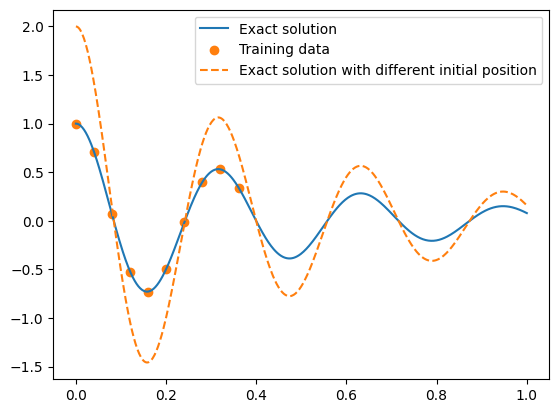

In [4]:
d, w0 = 2, 20


class ExactSolution:
    """Class to define the exact solution to the 1D underdamped harmonic oscillator problem."""

    def __init__(
        self,
        x: jnp.ndarray,
        d: float = 2.0,
        w0: float = 20.0,
        initial_position: float = 1.0,
    ):
        self.x = x
        self.d = d
        self.w0 = w0
        self.init_position = initial_position
        self.y = oscillator(d, w0, x, initial_position=initial_position)


class TrainData:
    """Class to define the training data for the 1D underdamped harmonic oscillator problem from exact solution."""

    def __init__(
        self, full_data: ExactSolution, n_points: int = 10, x_max: float = 0.4
    ):
        self.n_points = n_points
        self.x_max = x_max

        # Get the training data from the full data points
        x_subset = full_data.x[jnp.where((full_data.x >= 0) & (full_data.x <= x_max))]
        y_subset = full_data.y[jnp.where((full_data.x >= 0) & (full_data.x <= x_max))]

        len_subset = x_subset.shape[0]
        if len_subset < n_points:
            raise ValueError(
                f"Not enough points in the subset. Found {len_subset}, expected mimimum of {n_points}."
            )
        take_every = len_subset // n_points

        x_train = x_subset[0:len_subset:take_every]
        y_train = y_subset[0:len_subset:take_every]
        self.x = x_train.reshape(-1, 1)
        self.y = y_train.reshape(-1, 1)


# get the analytical solution over the full domain
x = jnp.linspace(0, 1, 500).reshape(-1, 1)
exact = ExactSolution(x)
exact2 = ExactSolution(x, initial_position=2.0)

y = oscillator(d, w0, x).reshape(-1, 1)
y2 = oscillator(d, w0, x, initial_position=2.0).reshape(-1, 1)
print(exact.x.shape, exact.y.shape)

# slice out a small number of points from the start
train = TrainData(exact, n_points=10, x_max=0.4)
print(train.x.shape, train.y.shape)


def plot_exact_and_train(exact, train):
    """Plot the exact solution and the training data."""
    plt.figure()
    plt.plot(exact.x, exact.y, label="Exact solution")
    plt.scatter(train.x, train.y, color="tab:orange", label="Training data")
    plt.legend()


plot_exact_and_train(exact, train)

plt.plot(
    exact.x,
    exact2.y,
    label="Exact solution with different initial position",
    linestyle="--",
)
plt.legend()
plt.show()

## Normal neural network

Next, we train a standard neural network (fully connected network) to fit these training points.

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [5]:
class FCN(nn.Module):
    "Defines a fully connected network using Flax"

    features: int
    n_layers: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_layers):
            x = nn.Dense(features=self.features)(x)
            x = nn.tanh(x)
        x = nn.Dense(features=1)(x)

        return x


  0%|          | 0/1000 [00:00<?, ?it/s]

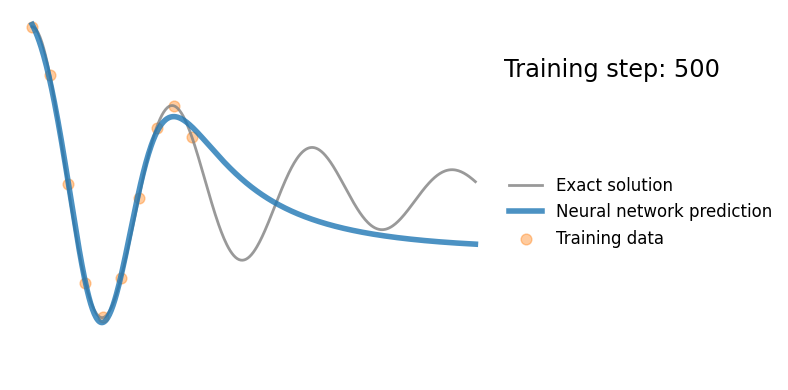

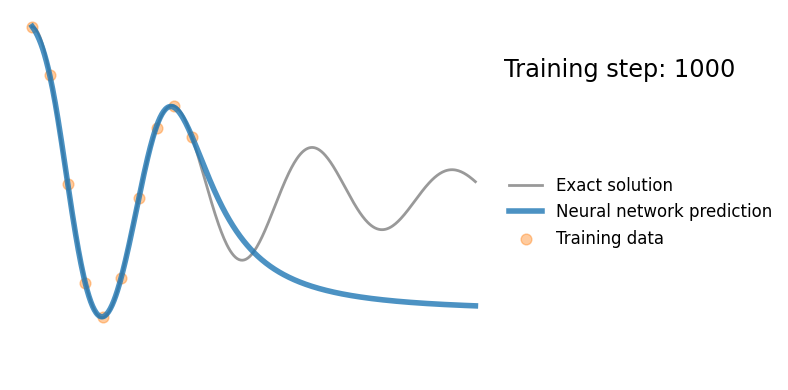

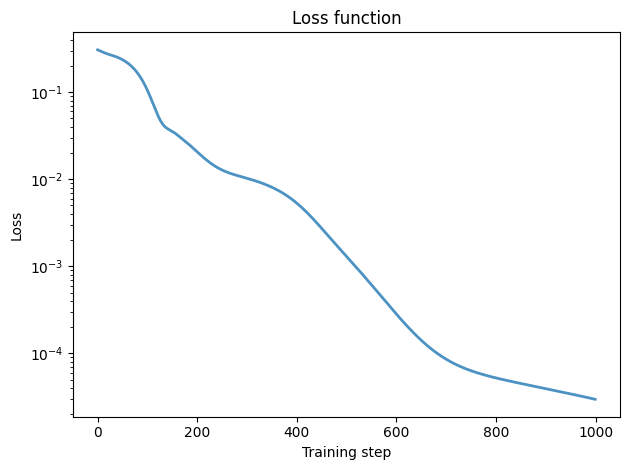

In [6]:
# Initialize neural network with JAX/Flax
key = jax.random.PRNGKey(0)

model = FCN(features=16, n_layers=3)

key, subkey = jax.random.split(key)
params = model.init(subkey, jnp.ones((1, 1)))


# Define loss function and optimizer
@jit
def loss_fn(params, x, y_true):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred - y_true) ** 2)


@jit
def update_step(params, optimizer_state, x, y):
    loss_value, grads = value_and_grad(loss_fn)(params, x, y)

    updates, optimizer_state = optimizer.update(grads, optimizer_state)

    params = optax.apply_updates(params, updates)

    return params, optimizer_state, loss_value


# Training loop for standard neural network
optimizer = optax.adam(learning_rate=1e-3)
optimizer_state = optimizer.init(params)

files = []
loss_recorder = []
with tempfile.TemporaryDirectory() as temp_dir:
    for i in tqdm(range(1000)):
        params, optimizer_state, loss = update_step(
            params, optimizer_state, train.x, train.y
        )
        loss_recorder.append(loss)

        # plot the result as training progresses
        if (i + 1) % 10 == 0:
            yh = model.apply(params, exact.x)

            plot_result(exact.x, exact.y, train.x, train.y, yh, step=i + 1)

            file = f"{temp_dir}/nn_{i + 1:08d}.png"
            plt.savefig(
                file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white"
            )
            files.append(file)

            if (i + 1) % 500 == 0:
                plt.show()
            else:
                plt.close("all")

    save_gif_PIL("nn.gif", files, fps=20, loop=0)

# Plot the loss function
plt.figure()
plt.plot(loss_recorder, color="tab:blue", linewidth=2, alpha=0.8)
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Loss function")
plt.tight_layout()
plt.show()

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using JAX's automatic differentiation, and can then easily compute the residual of the differential equation using these quantities.

In [7]:
class PhysicParams:
    """Class to hold the physics parameters for the model."""

    def __init__(self, w0, d):
        self.w0 = w0
        self.d = d

    def __repr__(self):
        return f"PhysicParams(w0={self.w0}, d={self.d})"


class PINN(nn.Module):
    """Physics-Informed Neural Network for the harmonic oscillator problem.
    This wraps the FCN model and adds physics-related parameters."""

    fcn: nn.Module  # The base neural network model
    params0: tuple[float, float] = (10.0, 1.0)  # Initial parameters for w0 and d

    def setup(self):
        # Initialize physics parameters (can be learnable parameters)
        self.w0 = self.param(
            "w0", nn.initializers.constant(self.params0[0]), (1,)
        )  # natural frequency
        self.d = self.param(
            "d", nn.initializers.constant(self.params0[1]), (1,)
        )  # damping coefficient

    def clamp_parameters(self, params):
        """Clamp the parameters w0 and d to a specific range."""
        params["params"]["w0"] = jnp.clip(
            params["params"]["w0"], 10, 50.0
        )  # Limited range for w0
        params["params"]["d"] = jnp.clip(
            params["params"]["d"], 0.5, 5.0
        )  # limited range for d
        return params

    def __call__(self, x) -> tuple[jnp.ndarray, PhysicParams]:
        """Forward pass through the"""
        # Get the base model prediction
        y = self.fcn(x)

        # Return both the prediction and physics parameters
        return y, PhysicParams(self.w0, self.d)

In [8]:
from typing import Callable

w0 = 10.0
d = 1.0

key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)

pinn = PINN(fcn=model, params0=(w0, d))
params = pinn.init(subkey, jnp.ones((1, 1)))

w0_init = params["params"]["w0"]
d_init = params["params"]["d"]

logger.info(f"Initial w0: {w0_init}, Initial d: {d_init}")

# Initialize the PINN optimizer
pinn_optimizer = optax.adam(learning_rate=1e-3)
pinn_optimizer_state = pinn_optimizer.init(params)

2025-11-20 10:35:17.978 | INFO     | __main__:<module>:15 - Initial w0: [10.], Initial d: [1.]


  0%|          | 0/300000 [00:00<?, ?it/s]

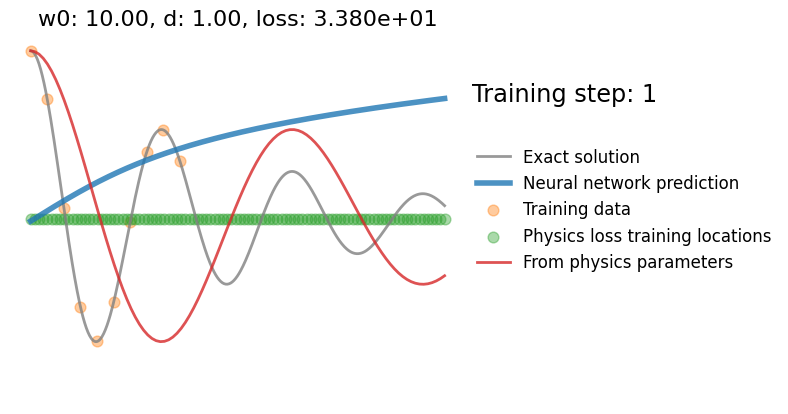

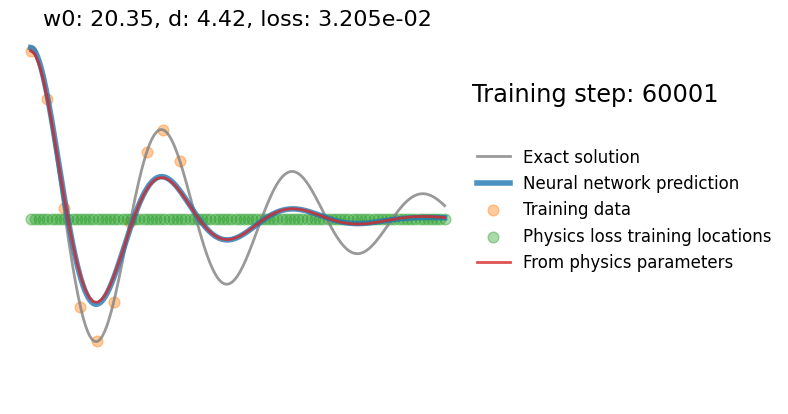

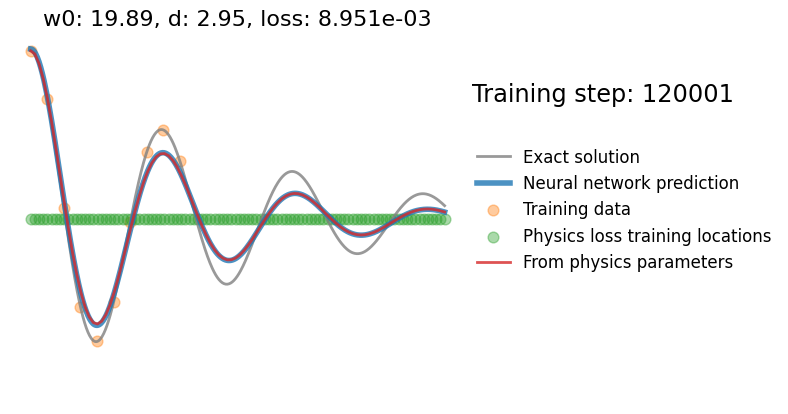

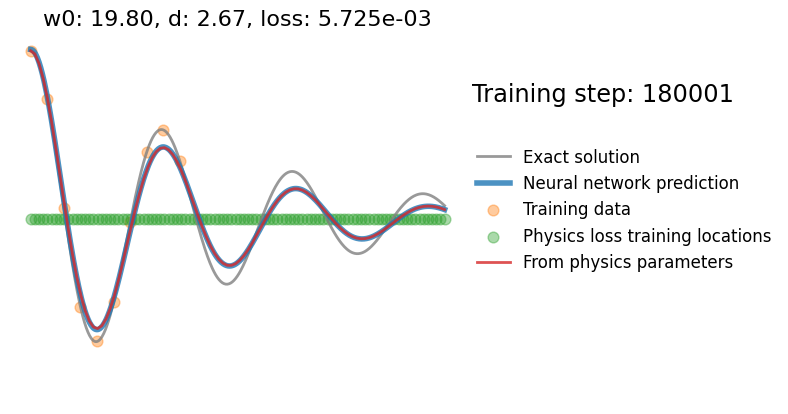

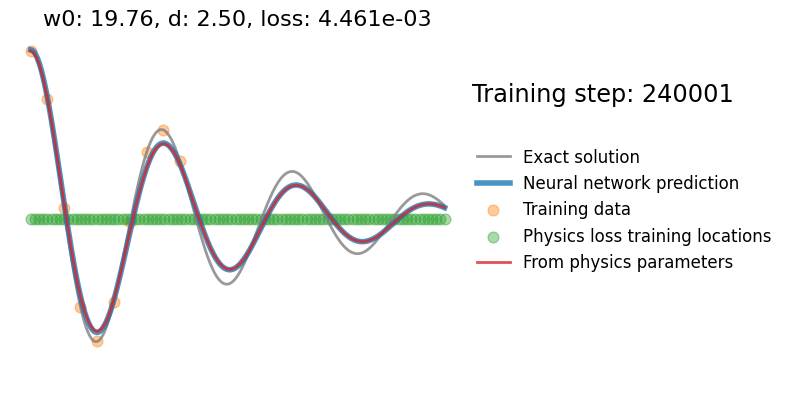

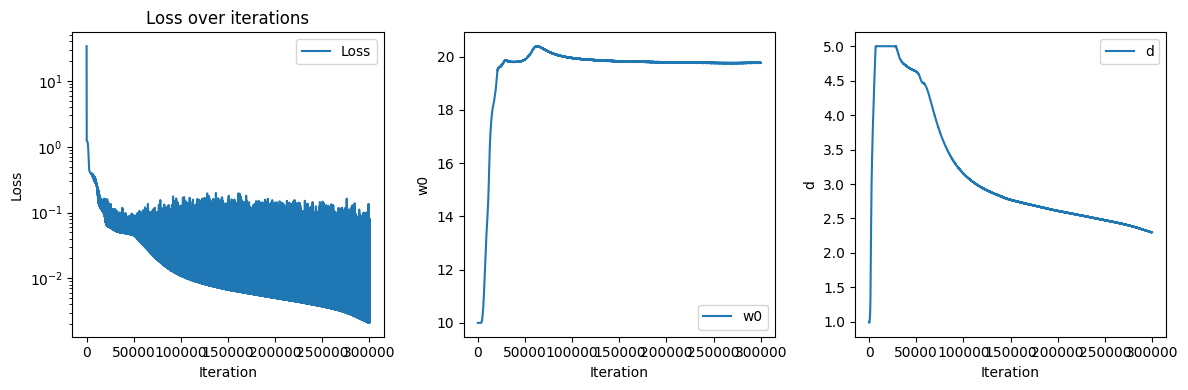

In [9]:
x_physics = jnp.linspace(0, 1, 100).reshape(-1, 1)


def pinn_fn(params, x):
    # Process a batch of data points and return the pinn predictions
    # Reshape x to have batch dimension for the model
    x_batched = jnp.reshape(x, (-1, 1))
    # Get the model prediction
    prediction = pinn.apply(params, x_batched)[0]

    return prediction


def diff(func: Callable, argnum=0):
    """sum then grad"""
    return jax.grad(lambda *args, **kwargs: jnp.sum(func(*args, **kwargs)), argnum)


# # Calculate the gradients for scalar inputs
first_derivative_scalar = diff(pinn_fn, argnum=1)
second_derivative_scalar = diff(first_derivative_scalar, argnum=1)


# Model loss function
@jit
def loss_nn(params, x_train, y_train):
    # Get model predictions
    y_pred, _ = pinn.apply(params, x_train)

    # Calculate the loss
    loss = jnp.mean((y_pred - y_train) ** 2).squeeze()

    return loss


# Physics loss function
@jit
def physics_loss(params, x_physics):
    # Get model predictions
    y, physics = pinn.apply(params, x_physics)

    # Calculate derivatives
    dy_dx = first_derivative_scalar(params, x_physics)
    d2y_dx2 = second_derivative_scalar(params, x_physics)

    # Extract physics parameters
    w0 = physics.w0
    d = physics.d
    mu = 2 * d
    k = w0**2

    # Compute physics residual
    physics_residual = d2y_dx2 + mu * dy_dx + k * y

    loss = jnp.mean(physics_residual**2).squeeze()

    return loss


# Initial condition loss function
@jit
def initial_condition_loss(params, x_train, y_train, dydx_0: float = 0.0):
    # Get model predictions
    x0 = x_train[0]  # Initial time
    y0 = y_train[0]  # Initial position
    dydx_0 = jnp.array([[dydx_0]])  # Initial velocity

    y, _ = pinn.apply(params, x0)

    dxdy = first_derivative_scalar(params, x0)

    # Calculate the initial condition loss
    loss = jnp.mean((y - y0) ** 2) + jnp.mean((dxdy - dydx_0) ** 2)

    return loss.squeeze()


@jit
def combined_loss(params, x_train, y_train, x_physics):
    data_loss = 1.0 * loss_nn(params, x_train, y_train)  # Loss of NN
    phys_loss = 1e-2 * physics_loss(params, x_physics)  # Loss of physics
    init_loss = 1.0 * initial_condition_loss(
        params, x_train, y_train, dydx_0=0.0
    )  # Loss of initial condition

    return data_loss + phys_loss + init_loss


@jit
def pinn_update_step(params, optimizer_state, x_train, y_train, x_physics):
    loss_value, grads = value_and_grad(combined_loss)(
        params, x_train, y_train, x_physics
    )
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    # Clamp the parameters w0 and d
    params = pinn.clamp_parameters(params)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss_value


class Metrics(object):
    def __init__(self):
        self.loss = []
        self.w0 = []
        self.d = []

    def add(self, loss, w0, d):
        self.loss.append(loss)
        self.w0.append(w0)
        self.d.append(d)

    def __repr__(self):
        return f"Metrics(loss={self.loss}, w0={self.w0}, d={self.d})"

    @property
    def str_last(self):
        return f"Metrics(loss={self.loss[-1]}, w0={self.w0[-1]}, d={self.d[-1]})"


metrics = Metrics()

files = []
n_epochs = 300000
n_images_show = 5
show_interval = n_epochs // n_images_show
n_images_gif = 100
gif_interval = n_epochs // n_images_gif

# Temporary directory for saving images
with tempfile.TemporaryDirectory() as temp_dir:
    # Training loop for physics-informed neural network
    for i in tqdm(range(n_epochs)):
        params, pinn_optimizer_state, loss = pinn_update_step(
            params, pinn_optimizer_state, train.x, train.y, x_physics
        )

        # Record the physics parameters and loss
        w0 = params["params"]["w0"]
        d = params["params"]["d"]

        metrics.add(loss, w0, d)

        # plot the result as training progresses
        if i % gif_interval == 0:
            yh, physics = pinn.apply(params, x)

            w0 = physics.w0
            d = physics.d

            # logger.info(
            #     f"Iteration {i + 1}: Loss: {loss:.3e}, w0: {w0[0]:.2f}, d: {d[0]:.2f}"
            # )

            plot_result(exact.x, exact.y, train.x, train.y, yh, x_physics, step=i + 1)
            plt.plot(
                x_physics,
                oscillator(d, w0, x_physics),
                color="tab:red",
                linewidth=2,
                alpha=0.8,
                label="From physics parameters",
            )
            plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")

            plt.title(f"w0: {w0[0]:.2f}, d: {d[0]:.2f}, loss: {loss:.3e}", fontsize=16)

            file = f"{temp_dir}/pinn_{i + 1:08d}.png"
            plt.savefig(
                file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white"
            )
            files.append(file)

            if i % show_interval == 0:
                plt.show()
            else:
                plt.close("all")

    save_gif_PIL("pinn.gif", files, fps=20, loop=0)


# Plot the loss and physics parameters over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(metrics.loss, label="Loss")
plt.yscale("log")
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(metrics.w0, label="w0")
plt.xlabel("Iteration")
plt.ylabel("w0")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(metrics.d, label="d")
plt.xlabel("Iteration")
plt.ylabel("d")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Extract the physics parameters

w0 = params["params"]["w0"][0]
d = params["params"]["d"][0]
print(f"Learned natural frequency (w0): {w0}")
print(f"Learned damping coefficient (d): {d}")


Learned natural frequency (w0): 19.762916564941406
Learned damping coefficient (d): 2.297250270843506


2025-11-20 10:36:10.739 | INFO     | __main__:<module>:11 - Time taken for PINN prediction: 0.0278 seconds


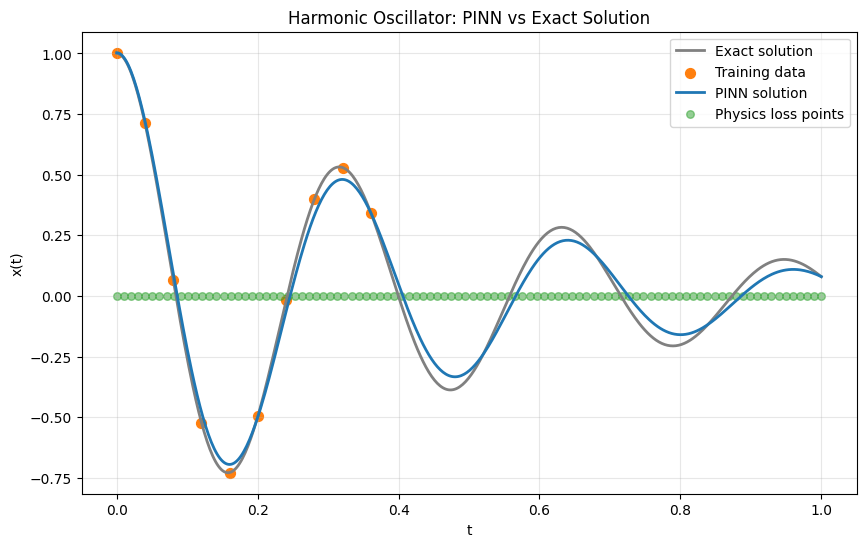

In [11]:
# Check how the PINN performs when the initial position is different


plt.figure(figsize=(10, 6))
plt.plot(exact.x, exact.y, color="grey", linewidth=2, label="Exact solution")
plt.scatter(train.x, train.y, color="tab:orange", s=50, label="Training data")

start_time = time.perf_counter()
yh = pinn.apply(params, exact.x)[0]
end_time = time.perf_counter()
logger.info(f"Time taken for PINN prediction: {end_time - start_time:.4f} seconds")

plt.plot(exact.x, yh, color="tab:blue", linewidth=2, label="PINN solution")
plt.scatter(
    x_physics,
    jnp.zeros_like(x_physics),
    color="tab:green",
    s=30,
    alpha=0.5,
    label="Physics loss points",
)
plt.legend(loc="best")
plt.title("Harmonic Oscillator: PINN vs Exact Solution")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Solve the ODE using scipy
from scipy.integrate import solve_ivp
import numpy as np
from scipy.optimize import minimize


def harmonic_oscillator(t, y, w0, d):
    """Define the system of ODEs for the harmonic oscillator."""
    dydt = [y[1], -2 * d * y[1] - w0**2 * y[0]]
    return dydt


def calculate_ode_solution(
    w0: float,
    d: float,
    y0: list[float, float],
    t_span: tuple[float, float],
    t_eval: np.ndarray,
):
    """
    Calculate the solution to the harmonic oscillator ODE using scipy's solve_ivp.
    Args:
        w0: Natural frequency
        d: Damping coefficient
        y0: Initial conditions [position, velocity]
        t_span: Time span for the solution (start, end)
        t_eval: Time points to evaluate the solution
    Returns:
        t: Time points
        y: Position values at the time points
    """
    # Solve the ODE
    sol = solve_ivp(
        harmonic_oscillator,
        t_span,
        y0,
        args=(w0, d),
        t_eval=t_eval,
        method="RK45",
        rtol=1e-8,
    )
    return sol.t, sol.y[0]


# Function to fit parameters to data
def fit_harmonic_oscillator(x_train, y_train, initial_guess=None):
    """
    Fit the parameters of harmonic oscillator to given data

    Args:
        x_train: Time points
        y_train: Position values
        initial_guess: Initial guess for [w0, d], defaults to [20.0, 2.0]

    Returns:
        w0_opt: Optimized natural frequency
        d_opt: Optimized damping coefficient
    """
    if initial_guess is None:
        initial_guess = [20.0, 2.0]

    y0 = [1.0, 0.0]  # Initial conditions: position and velocity
    t_span = (0, 1)  # Time span for the solution

    def residual(params):
        w0_test, d_test = params
        # Solve ODE with test parameters
        _, y_test = calculate_ode_solution(
            w0_test, d_test, y0, t_span, x_train.flatten()
        )

        # Calculate error between solution and data
        err = y_test - y_train.flatten()
        return np.sum(err**2)

    # Optimize parameters
    result = minimize(residual, initial_guess, method="Nelder-Mead")

    w0_opt, d_opt = result.x

    return w0_opt, d_opt


# Initial conditions
y0 = [1.0, 0.0]  # Initial position and velocity
t_span = (0, 1)  # Time span for the solution
t_eval = np.linspace(0, 1, 30)  # Time points to evaluate the solution

# Uncomment to fit parameters to data (optional)
w0_fit, d_fit = fit_harmonic_oscillator(train.x, train.y, [20.0, 2.0])

logger.debug(f"Fitted natural frequency (w0): {w0_fit}")
logger.debug(f"Fitted damping coefficient (d): {d_fit}")


# Solve the ODE
start_time = time.perf_counter()
ode_t, ode_y = calculate_ode_solution(w0_fit, d_fit, y0, t_span, t_eval)

end_time = time.perf_counter()

logger.debug(f"ODE solution time: {end_time - start_time:.4f} seconds")

2025-11-20 10:36:23.078 | DEBUG    | __main__:<module>:92 - Fitted natural frequency (w0): 20.0
2025-11-20 10:36:23.078 | DEBUG    | __main__:<module>:93 - Fitted damping coefficient (d): 2.0
2025-11-20 10:36:23.083 | DEBUG    | __main__:<module>:102 - ODE solution time: 0.0040 seconds


In [13]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add ODE solution trace
fig.add_trace(
    go.Scatter(
        x=ode_t,
        y=ode_y,
        mode="lines",
        line=dict(color="purple", width=2),
        name="ODE solution",
    )
)

# Add PINN solution trace
fig.add_trace(
    go.Scatter(
        x=x.flatten(),
        y=yh.flatten(),
        mode="lines",
        line=dict(color="blue", width=2),
        name="PINN solution",
    )
)

# Add training data trace
fig.add_trace(
    go.Scatter(
        x=train.x.flatten(),
        y=train.y.flatten(),
        mode="markers",
        marker=dict(color="orange", size=10),
        name="Training data",
    )
)

# Add exact solution trace
fig.add_trace(
    go.Scatter(
        x=exact.x.flatten(),
        y=exact.y.flatten(),
        mode="lines",
        line=dict(color="grey", width=2),
        name="Exact solution",
    )
)

# Update layout
fig.update_layout(
    title="Harmonic Oscillator: ODE vs PINN Solution",
    xaxis_title="t",
    yaxis_title="x(t)",
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99),
    width=900,
    height=600,
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.3)")
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.3)")

fig.show()